## Data Loading & Imports

This sections contains all the intial imports and sets up the ability to imnport the dataset classes from the data processing file.

In [1]:
# MOUNT DRIVE A THE FOLDER DIRECTORY
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### CHANGE THE `cd` PATH TO WHATEVER DIRECTORY THE MODEL FOLDER IS IN

In [2]:
# for Cairo
%cd "drive/MyDrive/APS360 Project /Model"

# for Kate
#%cd "/content/drive/MyDrive/APS360/Project /Model"
%pwd

/content/drive/.shortcut-targets-by-id/1iAsHu75MZqQi03g8IZnF4UG6jJs-pJjE/Project /Model


'/content/drive/.shortcut-targets-by-id/1iAsHu75MZqQi03g8IZnF4UG6jJs-pJjE/Project /Model'

In [3]:
from utils import ImageDataset

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import torchvision.models as models

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython import display

from skimage.io import imread
import skimage.io

### Initialize Datasets

In [5]:
# The following transforms are required in order to be compatiable with MobileNet
t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(
   name='Train',
   csv_file='large_training_data_onehot.csv',
   root_dir='Ham10000',
   transforms= t
)

validation_dataset = ImageDataset(
   name='Validation',
   csv_file='large_validation_data_onehot.csv',
   root_dir='Ham10000',
   transforms= t
)

test_dataset = ImageDataset(
   name='Test',
   csv_file='large_test_data_onehot.csv',
   root_dir='HIBA Images - Test',
   transforms= t
)

### Define Training Function

In [6]:
def training_curve(epochs, train_acc, train_losses, val_acc, val_losses):
    plt.title("Train vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


def train(model, classifer, train_set, val_set, num_epochs=1, learning_rate=1e-4, batch_size=64, weight_decay=0, patience=0, plot=True, print_batches=False):
    # get loaders with the appropriate batch size
    print('Getting Train Loaders')
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

    # Accumulators
    epochs = []

    # Training Accumulators
    train_losses = []
    train_accs = []

    # Validation Accumulators
    val_losses = []
    val_accs = []

    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay, lr=learning_rate)

    try: # sets up save if training is manually stopped
      start_time = time.time()
      print('Training Start')
      for epoch in range(num_epochs):
          # for progress tracking
          train_batch_num = 0
          val_batch_num = 0

          # for accuracy calc
          train_correct_predictions = 0
          val_correct_predictions = 0
          train_num_images = 0
          val_num_images = 0

          # Clears training output
          display.clear_output(wait=True)

          # Implementing early stopping with patience mechanism
          val_loss_counter = 0
          if epoch > 2 and (val_losses[-1] > val_losses[-2] or val_losses[-1] > val_losses[-3]):
            val_loss_counter += 1
          elif epoch > 2 and (val_losses[-1] <= val_losses[-2] or val_losses[-1] <= val_losses[-3]):
            val_loss_counter = 0

          print(f'Early Stop Counter: {val_loss_counter}')

          if val_loss_counter >= patience:
            print(f'Training Stopped Early due to Patience at Epoch {epoch + 1}')
            break

          # Printing graph and results at the start of each epoch so its visable throughout training
          for i in range(len(epochs)):
            print((f"Epoch {epochs[i] + 1}: Train Accuracy: {round(train_accs[i]*100, 6)}% | Valication Accuracy: {round(val_accs[i]*100, 6)}%"))

          # Attempting to implement dynamic plotting
          if plot:
            training_curve(epochs, train_accs, train_losses, val_accs, val_losses)
            display.display(plt.gcf())

          for data in train_loader:
              train_batch_start = time.time()
              train_batch_num += 1

              images, diagnosis, metadata = data

              #############################################
              #To Enable GPU Usage
              if use_cuda and torch.cuda.is_available():
                images = images.cuda()
                diagnosis = diagnosis.cuda()
                metadata = metadata.cuda()
              #############################################


              train_num_images += len(images) # getting total number of images

              outputs = model(images) # model output
              outputs = classifier(torch.cat((outputs, metadata), 1))

              prediction = outputs.max(1, keepdim=True)[1]
              train_correct_predictions += prediction.eq(diagnosis.max(1, keepdim=True)[1].view_as(prediction)).sum().item()
              train_acc = train_correct_predictions/train_num_images # calculate overall accuracy


              train_loss = criterion(outputs, diagnosis)
              train_loss.backward()

              optimizer.step()
              optimizer.zero_grad()

              train_batch_end = time.time()

              if print_batches:
                print(f'\nT{train_batch_num}: Training Accuracy: {round(float(train_acc)*100, 2)}%')
                print(f'T{train_batch_num}: Training Loss: {round(float(train_loss), 2)}')

          for data in val_loader:
              val_batch_start = time.time()
              val_batch_num += 1

              images, diagnosis, ben_or_mal = data

              #############################################
              #To Enable GPU Usage
              if use_cuda and torch.cuda.is_available():
                images = images.cuda()
                diagnosis = diagnosis.cuda()
                ben_or_mal = ben_or_mal.cuda()
              #############################################

              val_num_images += len(images)

              outputs = model(images)

              prediction = outputs.max(1, keepdim=True)[1]
              val_correct_predictions += prediction.eq(diagnosis.max(1, keepdim=True)[1].view_as(prediction)).sum().item()
              val_acc = val_correct_predictions/val_num_images # calculate overall accuracy


              val_loss = criterion(outputs, diagnosis)

              val_batch_end = time.time()

              if print_batches:
                print(f'\nV{val_batch_num}: Validation Accuracy: {round(float(val_acc)*100, 2)}%')
                print(f'V{val_batch_num}: Validation Loss: {round(float(val_loss), 2)}')

          # Data Accumulation & Reporting
          epochs.append(epoch)

          train_losses.append(float(train_loss)/len(train_loader))
          train_accs.append(train_acc)

          val_losses.append(float(val_loss)/len(train_loader))
          val_accs.append(val_acc)

          print((f"\nEpoch {epoch + 1}: Train Accuracy: {round(train_accs[epoch]*100, 6)}% | Valication Accuracy: {round(val_accs[epoch]*100, 6)}%"))

    except KeyboardInterrupt:
        model_path =  f'Saved Models/Pretrained Models/model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epochs[-1] + 1}'
        torch.save(model.state_dict(), model_path)

        model_path =  f'Saved Models/Pretrained Models/model_{classifier.name}_bs{batch_size}_lr{learning_rate}_epoch{epochs[-1] + 1}'
        torch.save(classifer.state_dict(), model_path)

        end_time = time.time()

        display.clear_output(wait=True)

        epochs_completed = epochs[-1] + 1

        if plot:
          training_curve(epochs, train_accs, train_losses, val_accs, val_losses)
        print(f'\nNumber of Epochs: {epochs_completed}')
        print(f'Training Time Ellapsed: {round((end_time - start_time)/60, 2)} minutes')
        print(f"Training Accuracy Results: {train_accs[-1]*100}")
        print(f"Validation Accuracy Results: {val_accs[-1]*100}")

        dataframe = pd.DataFrame()
        dataframe.insert(loc=0, column='epochs', value=epochs)
        dataframe.insert(loc=1, column='train_loss', value=train_losses)
        dataframe.insert(loc=2, column='val_loss', value=val_losses)
        dataframe.insert(loc=3, column='tran_acc', value=train_accs)
        dataframe.insert(loc=4, column='val_acc', value=val_accs)

        return dataframe, epochs_completed

    # If model goes to completion, it does the same thing
    model_path =  f'Saved Models/Autoencoder Models/model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epoch + 1}'
    torch.save(model.state_dict(), model_path)

    model_path =  f'Saved Models/Pretrained Models/model_{classifier.name}_bs{batch_size}_lr{learning_rate}_epoch{epochs[-1] + 1}'
    torch.save(classifer.state_dict(), model_path)

    end_time = time.time()

    display.clear_output(wait=True)

    epochs_completed = epochs[-1] + 1

    if plot:
      training_curve(epochs, train_accs, train_losses, val_accs, val_losses)

    print(f'\nNumber of Epochs: {epochs_completed}')
    print(f'\nTraining Time Ellapsed: {round((end_time - start_time)/60, 2)} minutes')
    print(f"Training Accuracy Results: {train_accs[-1]*100}")
    print(f"Validation Accuracy Results: {val_accs[-1]*100}")

    dataframe = pd.DataFrame()
    dataframe.insert(loc=0, column='epochs', value=epochs)
    dataframe.insert(loc=1, column='train_loss', value=train_losses)
    dataframe.insert(loc=2, column='val_loss', value=val_losses)
    dataframe.insert(loc=3, column='tran_acc', value=train_accs)
    dataframe.insert(loc=4, column='val_acc', value=val_accs)

    return dataframe, epochs_completed


# Convolutional Autoencoder
This style of autoencoder was picked due to it effectiveness at classifying images.

In [7]:
model = models.mobilenet_v2(pretrained=True)

model.name = 'MobileNetV2Extraction'

model.classifier = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(1280, 500),
    nn.ReLU(),
    nn.Linear(500, 50),
    nn.ReLU(),
    nn.Linear(50, 7)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model = models.mobilenet_v2(pretrained=True)

model.name = 'MobileNetV2FourLayerClassifer'

model.classifier = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(1280, 500),
    nn.ReLU(),
    nn.Linear(500, 100),
    nn.ReLU(),
    nn.Linear(100, 30),
    nn.ReLU(),
    nn.Linear(30, 7)
)

In [9]:
model = models.mobilenet_v2(pretrained=True)

model.name = 'MobileNet4Features'

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.name = 'Classifier'
        self.classifier = nn.Sequential(
              nn.Dropout(0.1),
              nn.Linear(1272, 500),
              nn.ReLU(),
              nn.Linear(500, 100),
              nn.ReLU(),
              nn.Linear(100, 30),
              nn.ReLU(),
              nn.Linear(30, 7)
      )

    def forward(self, x):
        x = self.classifier(x)
        x.squeeze(1)
        return x

classifier = Classifier()

Early Stop Counter: 0


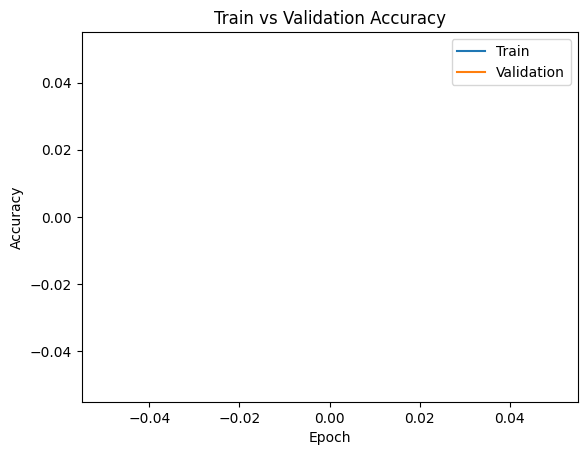

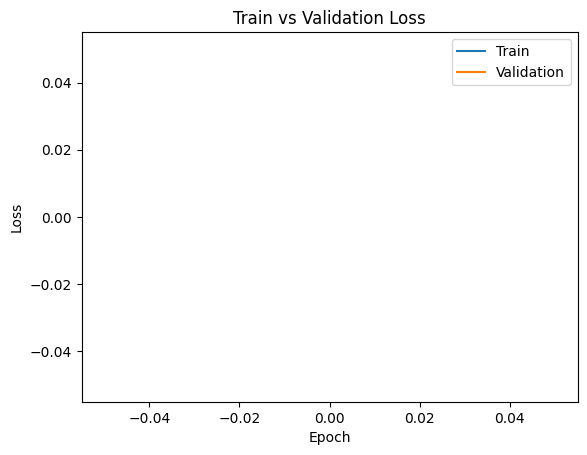

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



T1: Training Accuracy: 15.62%
T1: Training Loss: 1.96

T2: Training Accuracy: 14.06%
T2: Training Loss: nan

T3: Training Accuracy: 12.5%
T3: Training Loss: nan

T4: Training Accuracy: 13.28%
T4: Training Loss: nan

T5: Training Accuracy: 14.37%
T5: Training Loss: nan

T6: Training Accuracy: 14.06%
T6: Training Loss: nan

T7: Training Accuracy: 14.29%
T7: Training Loss: nan

T8: Training Accuracy: 14.06%
T8: Training Loss: nan

T9: Training Accuracy: 14.24%
T9: Training Loss: nan

T10: Training Accuracy: 15.31%
T10: Training Loss: nan

T11: Training Accuracy: 14.77%
T11: Training Loss: nan

T12: Training Accuracy: 14.58%
T12: Training Loss: nan

T13: Training Accuracy: 13.94%
T13: Training Loss: nan

T14: Training Accuracy: 14.73%
T14: Training Loss: nan

T15: Training Accuracy: 15.0%
T15: Training Loss: nan

T16: Training Accuracy: 15.82%
T16: Training Loss: nan

T17: Training Accuracy: 16.36%
T17: Training Loss: nan

T18: Training Accuracy: 16.49%
T18: Training Loss: nan

T19: Train

RuntimeError: ignored

<Figure size 640x480 with 0 Axes>

In [10]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  classifier.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

num_epochs = 400
batch_size = 32
learning_rate = 5e-7
weight_decay = 0.001
patience = 3
print_batches=True

training_values, epochs_completed = train(model, classifier, train_dataset, validation_dataset, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, weight_decay=weight_decay, patience=patience, print_batches=print_batches)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def test_model(model, test_dataset, batch_size):
    print('Fetching Loader')
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # for accuracy calc
    correct_predictions = 0
    num_images = 0

    # for confustion matrix
    predictions = []
    labels = []

    batch_num = 0
    for i, data in enumerate(test_loader, 0):
        batch_num += 1
        print(f'Batch Number: {batch_num}')
        images, diagnosis, ben_or_mal = data

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          images = images.cuda()
          diagnosis = diagnosis.cuda()
          ben_or_mal = ben_or_mal.cuda()
        #############################################

        num_images += len(images)

        # get output from model
        outputs = model(images)


        # Model Prediction
        prediction = outputs.max(1, keepdim=True)[1]
        predictions.extend(prediction.cpu().numpy())

        # Ground Truth Label
        label = diagnosis.max(1, keepdim=True)[1]
        labels.extend(label.cpu().numpy())

        correct_predictions += prediction.eq(label.view_as(prediction)).sum().item()

    acc = correct_predictions/num_images # calculate overall accuracy
    print(f"\nOverall Accuracy: {acc*100}%")

    return acc, predictions, labels

def plot_cm(labels, predictions, test_dataset):
    cm = confusion_matrix(labels, predictions)
    cm_matrix = pd.DataFrame(data=cm,
        columns=[f'Predicted {diag}' for diag in test_dataset.column_values['diagnosis']],
        index=[f'Actual {diag}' for diag in test_dataset.column_values['diagnosis']]
    )

    m = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
    m.set_xticklabels(m.get_xticklabels(), rotation = 35, horizontalalignment='right')
    return m, cm_matrix

In [ ]:
good_model = models.mobilenet_v2(weights=True)

for param in model.features.parameters():
  param.requires_grad = False

good_model.name = 'MobileNet4Features'

good_model_path = f"Saved Models/Pretrained Models/model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epochs_completed}"

use_cuda = True

if use_cuda and torch.cuda.is_available():
  saved_state = torch.load(good_model_path)
  good_model.load_state_dict(saved_state)
  good_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  saved_state = torch.load(good_model_path, map_location=torch.device('cpu'))
  good_model.load_state_dict(saved_state)

test_acc, prediction, labels = test_model(good_model, test_dataset, batch_size=64)


In [ ]:
from sklearn.metrics import classification_report
print(f'Test Accuracy of {good_model_path}: {test_acc*100}')
heat_map, cm_matrix = plot_cm(labels, prediction, test_dataset)

print(classification_report(labels, prediction))